## 2. Frame Extraction

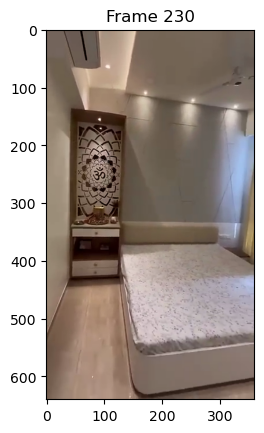

In [ ]:
'''
import imageio.v3 as iio
import os

# --- Configuration ---
video_path = '../videos/bedroomvideo.mp4' # Path to your video file
output_folder = '../images/' # Folder where extracted frames will be saved
frame_interval = 10 

# --- Main Logic ---

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created output folder: {output_folder}")

print(f"Opening video file: {video_path}")

frame_count = 0
saved_frame_count = 0

try:
    # Iterate through frames in the video file without loading everything into memory
    for frame in iio.imiter(video_path):
        # Check if the current frame is one we should save based on the interval
        if frame_count % frame_interval == 0:
            # Construct the output filename (e.g., frame_0000.png, frame_0010.png)
            # Using PNG by default with imageio, but JPG is also possible
            output_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")

            # Save the frame as a PNG image
            iio.imwrite(output_filename, frame)
            # print(f"Saved frame: {output_filename}") # Uncomment for verbose output
            saved_frame_count += 1

        frame_count += 1

except FileNotFoundError:
    print(f"Error: Video file not found at {video_path}")
except Exception as e:
    print(f"An error occurred while processing the video: {e}")


print(f"\nFinished processing video.")
print(f"Total frames iterated: {frame_count}")
print(f"Frames saved (at interval {frame_interval}): {saved_frame_count}")
print(f"Extracted frames saved in folder: {output_folder}")
'''

import imageio
import matplotlib.pyplot as plt

frame_interval = 10
frames = []

reader = imageio.get_reader('../videos/bedroomvideo.mp4')
for i, frame in enumerate(reader):
    if i % frame_interval == 0:
        frames.append(frame)
        plt.imshow(frame)
        plt.title(f'Frame {i}')
        plt.show()